In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.signal import savgol_filter
%matplotlib inline

In [2]:
import sys
np.set_printoptions(threshold=sys.maxsize)

In [3]:
disp_figs = True

In [4]:
M = 4 # Number of Spiking motifs
N = 10 # Number of input neurons
D = 31 # temporal depth of receptive field
T = 1000
dt = 1
nrn_fr = 40 # hz
pg_fr = 4 # hz
background_noise_fr = 0 # h

np.random.seed(41)

In [5]:
# for matplotlib
colors = np.array(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
len(colors)

10

# Generate the PG Kernels


In [6]:
# I will try and do this with dense and sparse representations at the same time
# Dense K: matrix of binary images of sizeNxDxM
# Sparse K: set of (delay d, neuron a, and pg b)

K_dense = np.random.randint(0,999,(N,D,M))
K_dense[K_dense < nrn_fr] = 1
K_dense[K_dense >= nrn_fr] = 0
K_sparse = np.where(K_dense)

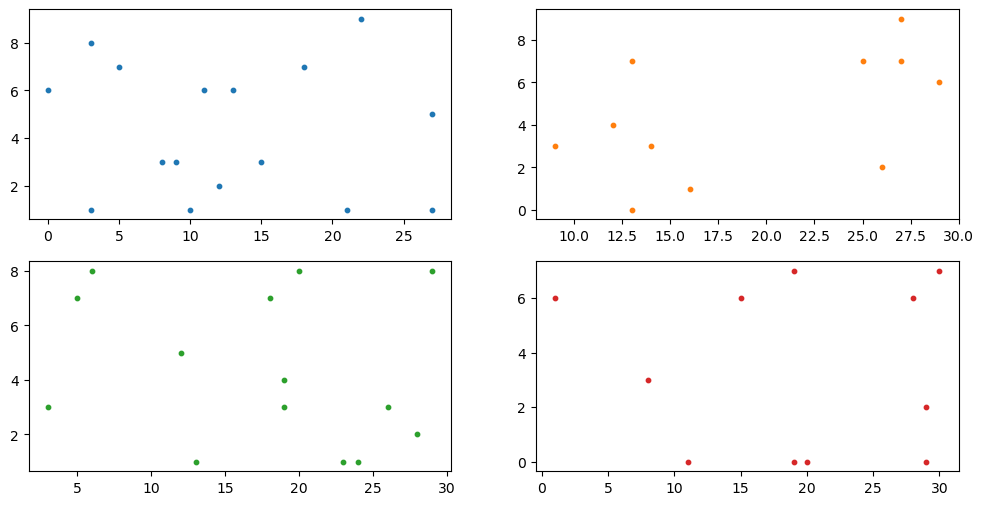

In [7]:

if disp_figs:
    %matplotlib inline
    fig,ax = plt.subplot_mosaic('AB;CD',figsize=(12,6))
    [ax[k].scatter(K_sparse[1][K_sparse[2]==i], K_sparse[0][K_sparse[2]==i],c=colors[i],s=10) for i,k in enumerate(['A','B','C','D'])]

# Generate the PG occurrences


In [8]:
# I suppose I can also do this in sparse and dense
# dense B: the binary image of the occurrences of the spiking motif as a ( M x T) matrix
# spare B: set of all times t and pg's b
B_dense = np.random.randint(0,999,(M,T))
B_dense[B_dense < pg_fr] = 1
B_dense[B_dense >= pg_fr] = 0
B_sparse = np.where(B_dense)

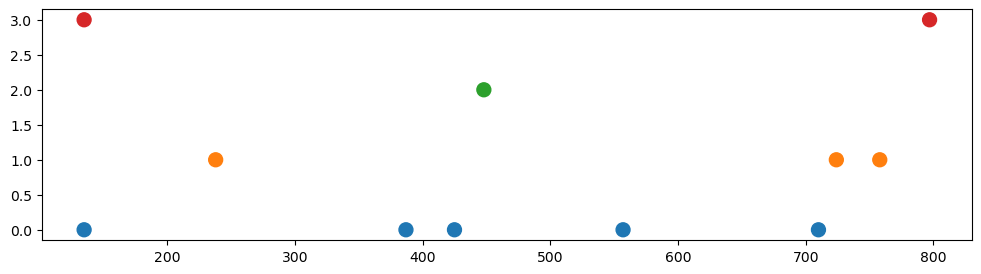

In [9]:
plt.figure(figsize=(12,3))
plt.scatter(B_sparse[1],B_sparse[0],c=colors[B_sparse[0]],s=100)
plt.show()

# Convolve the PG kernels with the PG firing times

In [10]:
# now to make the full raster plot keeping the labels in-tact
# dense A: the layered binary images of all neuron spikes by PG ( N x T x M
A_dense = np.zeros((N,T+D,M+1))
A_dense[...,-1] = np.random.randint(0,999,(N,T+D))
A_dense[...,-1] = (A_dense[...,-1] < background_noise_fr).astype('int')
for i in range(len(B_sparse[0])):
    t = B_sparse[1][i]
    b = B_sparse[0][i]
    A_dense[:, t:t+D, b] += K_dense[...,b]
    
A_dense.shape
# A_dense = A_dense[:,:1000,:]
A_sparse = np.where(A_dense)
A_dense = np.sum(A_dense,axis=2)
A_dense[A_dense>1] = 1
A_dense.shape

(10, 1031)

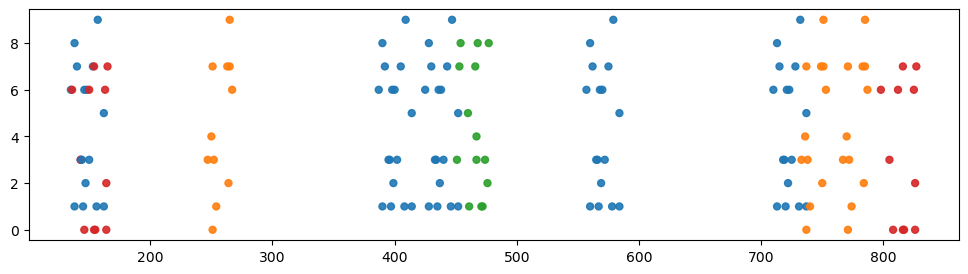

In [153]:
%matplotlib inline
plt.figure(figsize=(12,3))
plt.scatter(A_sparse[1],A_sparse[0],c=colors[A_sparse[2]],alpha=0.9,s=100,marker='.')
plt.show()

# Sanity Check

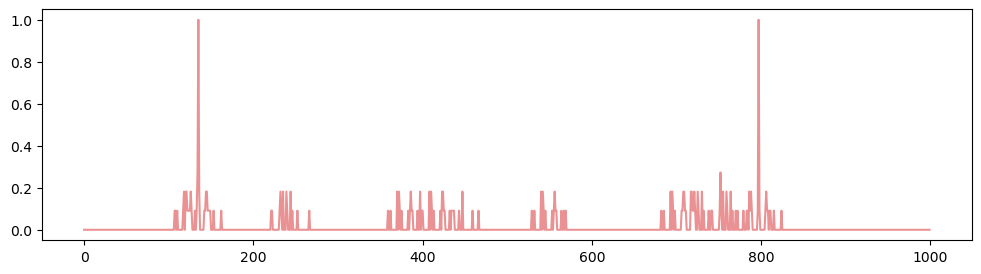

In [12]:
test = np.zeros((T,M))
%matplotlib inline
for j in range(M):
    for i in range(T):
        test[i,j] = np.sum(K_dense[...,j]*A_dense[:,i:i+D])
    test[:,j] = test[:,j]/np.max(test[:,j])
plt.figure(figsize=(12,3))
i = 3
plt.plot(test[:,i],color=colors[i],alpha=0.5)

# Unsupervised Learning

In [129]:
test_row = 0

In [130]:
window_dim = (int(np.ceil(D/2)), N)
valid_spikes = (A_sparse[1] > window_dim[0]) & (A_sparse[1] < T- window_dim[0])

In [131]:
M_labels = A_sparse[2][valid_spikes]
N_labels = A_sparse[0][valid_spikes]
T_labels = A_sparse[1][valid_spikes]
windows = np.zeros((len(T_labels), N, window_dim[0]*2))
for i,window_time in enumerate(T_labels):
    windows[i,...] = A_dense[:,-window_dim[0]+window_time:window_dim[0]+window_time]
#     windows[i,N_labels[i],window_dim[0]] = 2
print('spikes: %d, neurons: %s, depth: %a' %windows.shape)

spikes: 149, neurons: 10, depth: 32


In [207]:
test = windows[N_labels==test_row]
test.shape

(11, 10, 32)

In [133]:
result = np.zeros((test.shape[0],test.shape[0],10,32))

In [134]:
x = np.zeros((len(test),len(test)))
for i in range(test.shape[0]):
    for j in range(test.shape[0]):
        result[i,j,...] = test[i]*test[j] 
        x[i,j] = np.sum(test[i]*test[j])#/ max(np.sum(test[i]),np.sum(test[j]))


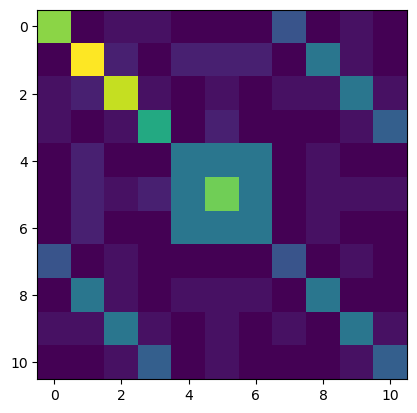

In [135]:
%matplotlib inline
plt.figure()
plt.imshow(x)

## Hierarchical Clustering


In [136]:
dissimilarity = 1 - x
cutoff = 1


In [137]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [138]:
debug = linkage(dissimilarity, method='complete')

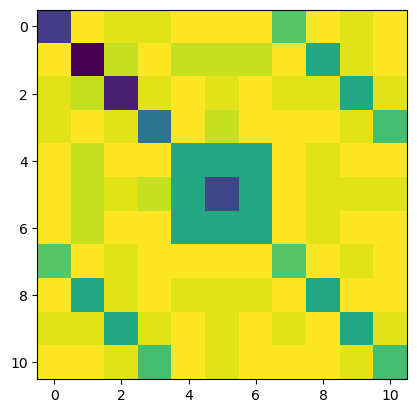

In [139]:
plt.figure()
plt.imshow(dissimilarity)

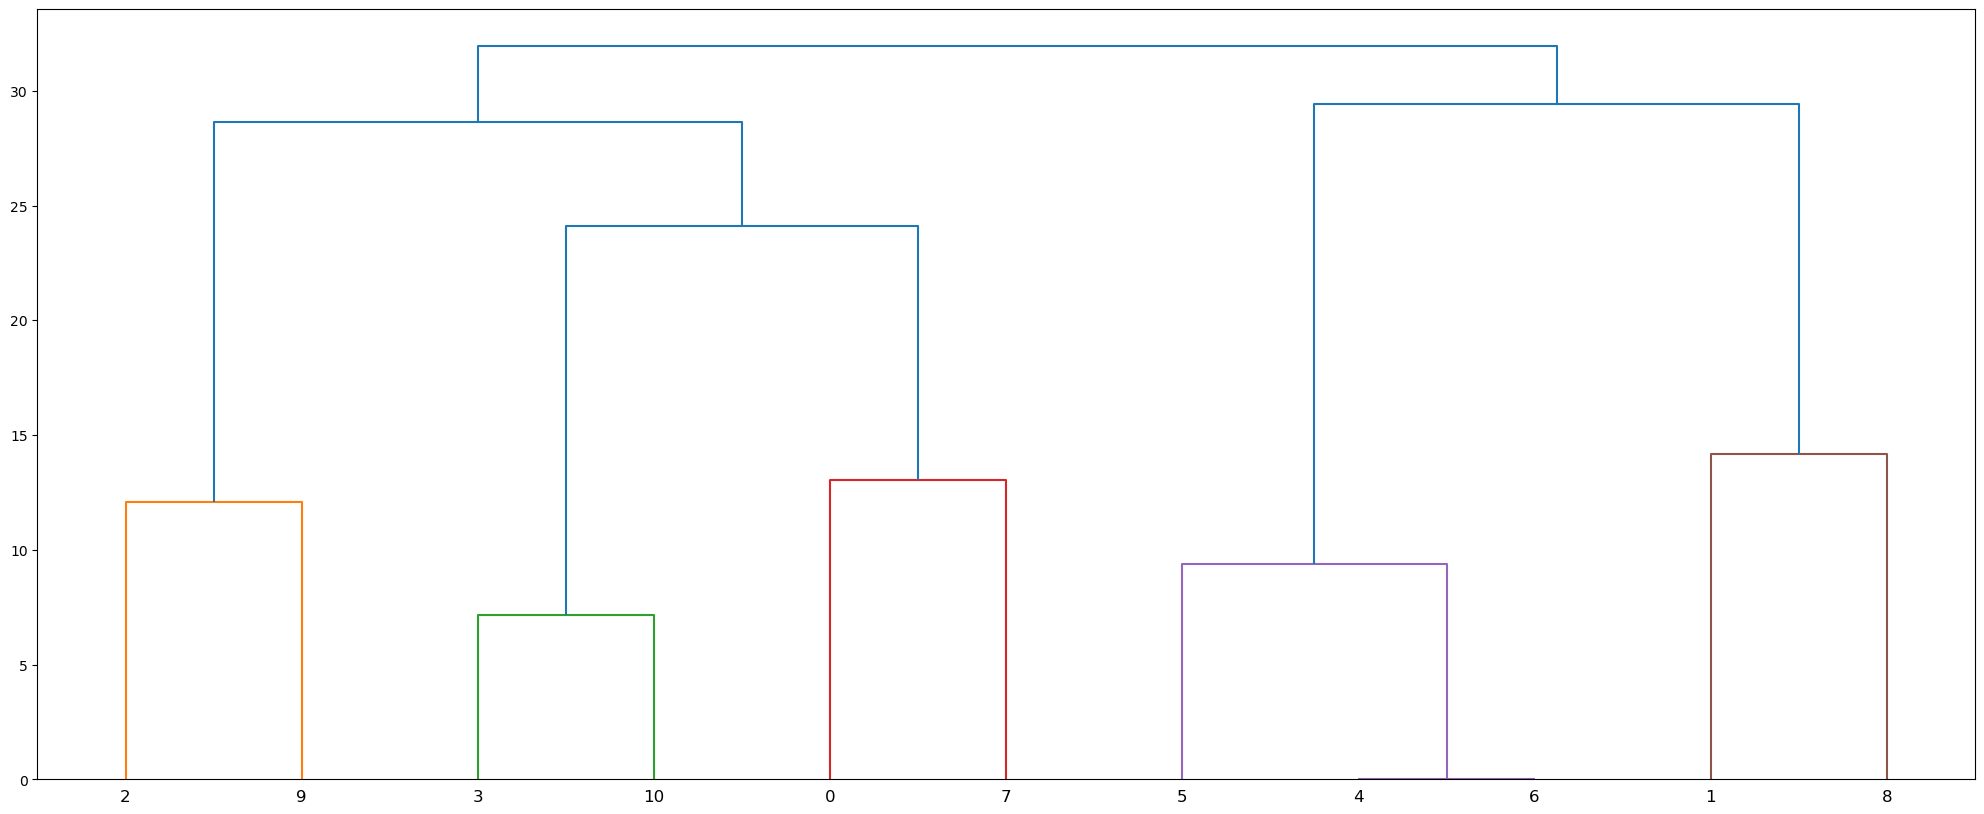

In [140]:
%matplotlib inline
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(debug)

In [148]:
from scipy.cluster.hierarchy import fcluster

# Set the cutoff value for clustering
cutoff = 30

# Get the cluster assignments for each spike based on the hierarchical clustering
clusters = fcluster(debug, cutoff, criterion='distance')
print(clusters, A_sparse[2][A_sparse[0]==test_row])

[1 2 1 1 2 2 2 1 2 1 1] [3 3 3 3 1 1 1 3 3 3 3]


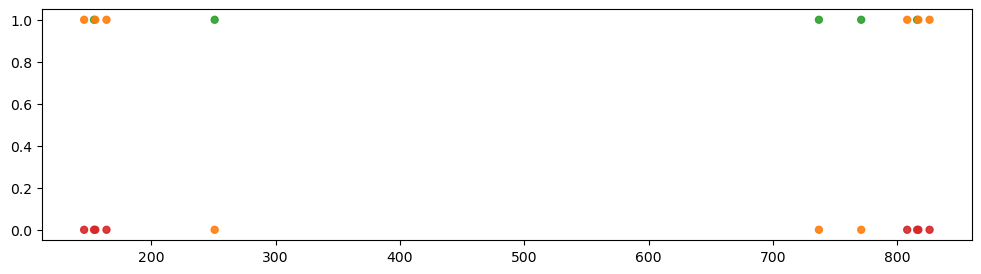

In [149]:
%matplotlib inline
plt.figure(figsize=(12,3))
plt.scatter(A_sparse[1][A_sparse[0]==test_row],A_sparse[0][A_sparse[0]==test_row],c=colors[A_sparse[2][A_sparse[0]==test_row]],alpha=0.9,s=100,marker='.')
plt.scatter(A_sparse[1][A_sparse[0]==test_row],1+A_sparse[0][A_sparse[0]==test_row],c=colors[clusters],alpha=0.9,s=100,marker='.')

plt.show()

In [73]:
M_labels[N_labels==1]

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1], dtype=int64)

# Window convolution

In [155]:
windows.shape,A_dense.shape

((149, 10, 32), (10, 1031))

In [161]:
from scipy.signal import convolve2d

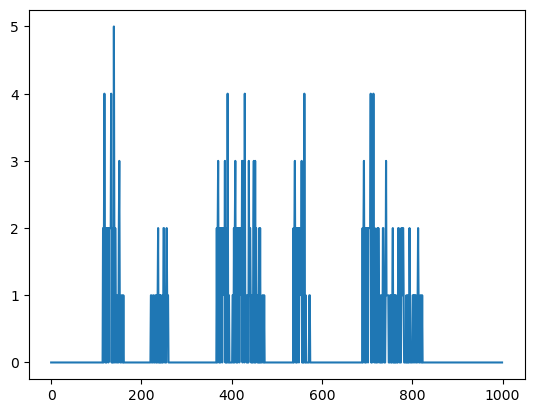

In [184]:
plt.figure()
plt.plot(np.arange(0,f.shape[1]),f.squeeze())
plt.show()

In [185]:
result = np.zeros((windows.shape[0],windows.shape[0],10,32))

In [197]:
min(np.sum(windows[0]), np.sum(windows[1]))

20.0

In [198]:
x = np.zeros((len(windows),len(windows)))
similarity = 0
for i in range(windows.shape[0]):
    for j in range(windows.shape[0]):
        
        result[i,j,...] = windows[i]*windows[j] 
        x[i,j] = np.sum(windows[i]*windows[j])/ min(np.sum(windows[i]),np.sum(windows[j]))


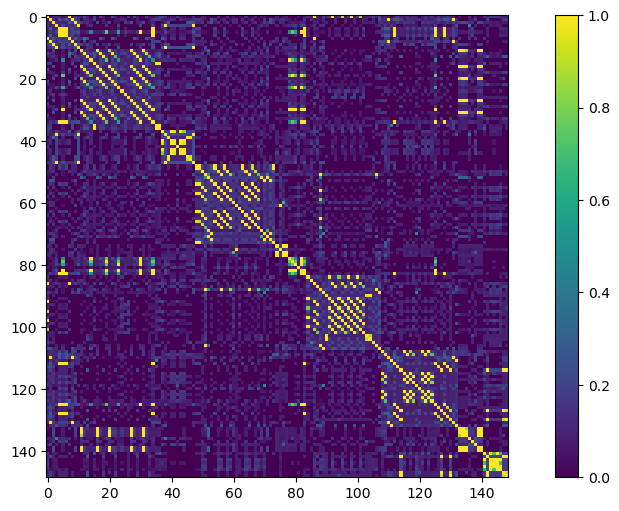

In [201]:
%matplotlib inline
plt.figure(figsize=(12,6))
im = plt.imshow(x)
plt.colorbar(im)

In [194]:
result_flat = result.reshape(result.shape[0]*result.shape[1],result.shape[2],result.shape[3])
result_flat.shape

(22201, 10, 32)

Global cross-correlation of all windows

In [202]:
import numpy as np

def compute_cross_correlation(windows):
    num_windows = len(windows)
    window_length = windows.shape[2]
    max_correlation_matrix = np.zeros((num_windows, num_windows))
    shift_matrix = np.zeros((num_windows, num_windows), dtype=int)

    for i in range(num_windows):
        for j in range(num_windows):
            # Compute cross-correlation between window[i] and window[j]
            correlation = np.correlate(windows[i].flatten(), windows[j].flatten(), mode='full')

            # Find the maximum correlation and its corresponding shift
            max_correlation = np.max(correlation)
            shift = np.argmax(correlation) - (correlation.size - 1) // 2

            # Store the results in the matrices
            max_correlation_matrix[i, j] = max_correlation
            shift_matrix[i, j] = shift

    return max_correlation_matrix, shift_matrix

# Assuming you have "windows" with shape (149, 10, 31)
# Call the function to compute cross-correlations
max_correlation_matrix, shift_matrix = compute_cross_correlation(windows)

# Now you have the two matrices: max_correlation_matrix and shift_matrix,
# which store the maximum correlation and corresponding shift for each pair of windows.


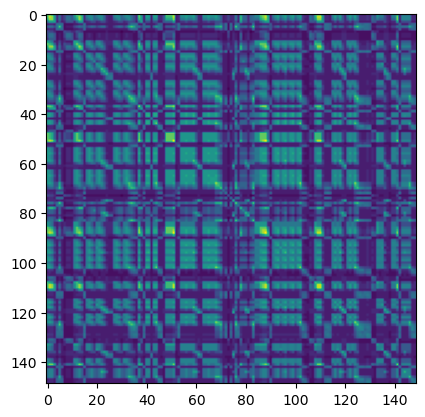

In [203]:
plt.figure()
plt.imshow(max_correlation_matrix)

In [208]:
test_max_correlation_matrix, test_shift_matrix = compute_cross_correlation(test)


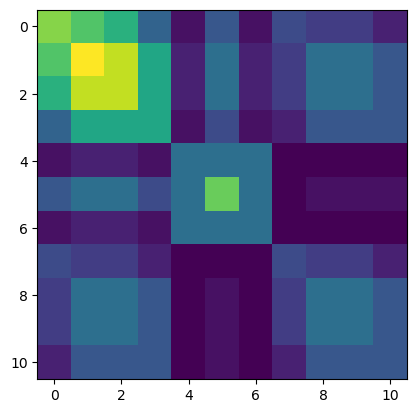

In [209]:
plt.figure()
plt.imshow(test_max_correlation_matrix)

In [235]:
test_max_correlation_matrix

array([[20., 18., 16.,  9.,  3.,  8.,  3.,  7.,  6.,  6.,  4.],
       [18., 24., 22., 15.,  4., 10.,  4.,  6., 10., 10.,  8.],
       [16., 22., 22., 15.,  4., 10.,  4.,  6., 10., 10.,  8.],
       [ 9., 15., 15., 15.,  3.,  7.,  3.,  4.,  8.,  8.,  8.],
       [ 3.,  4.,  4.,  3., 10., 10., 10.,  2.,  2.,  2.,  2.],
       [ 8., 10., 10.,  7., 10., 19., 10.,  2.,  3.,  3.,  3.],
       [ 3.,  4.,  4.,  3., 10., 10., 10.,  2.,  2.,  2.,  2.],
       [ 7.,  6.,  6.,  4.,  2.,  2.,  2.,  7.,  6.,  6.,  4.],
       [ 6., 10., 10.,  8.,  2.,  3.,  2.,  6., 10., 10.,  8.],
       [ 6., 10., 10.,  8.,  2.,  3.,  2.,  6., 10., 10.,  8.],
       [ 4.,  8.,  8.,  8.,  2.,  3.,  2.,  4.,  8.,  8.,  8.]])

In [212]:
import numpy as np

# Function to calculate Jaccard similarity between two windows
def jaccard_similarity(window1, window2):
    intersection = np.sum(np.logical_and(window1, window2))
    union = np.sum(np.logical_or(window1, window2))
    
    # Handle division by zero
    if union == 0:
        return 0
    
    return intersection / union

# Function to find clusters using Jaccard similarity with temporal shifts
def find_clusters(windows, threshold):
    num_windows = windows.shape[0]
    clusters = []

    # Step 1: Compute Jaccard Similarity with Temporal Shifts
    similarity_matrix = np.zeros((num_windows, num_windows))
    for i in range(num_windows):
        for j in range(i + 1, num_windows):
            max_similarity = 0
            max_shift = 0
            for shift in range(-windows.shape[2] + 1, windows.shape[2]):
                if shift < 0:
                    similarity = jaccard_similarity(windows[i, :, -shift:], windows[j, :, :shift])
                else:
                    similarity = jaccard_similarity(windows[i, :, :windows.shape[2] - shift], windows[j, :, shift:])
                if similarity > max_similarity:
                    max_similarity = similarity
                    max_shift = shift
            similarity_matrix[i, j] = max_similarity
            similarity_matrix[j, i] = max_similarity

    # Step 2: Threshold the Similarity Scores
    above_threshold_indices = np.where(similarity_matrix >= threshold)
    
    # Step 3: Identify Clusters
    for i, j in zip(above_threshold_indices[0], above_threshold_indices[1]):
        if i not in [c[-1] for c in clusters] and j not in [c[-1] for c in clusters]:
            clusters.append([i, j])

    # Step 4: Merge Overlapping Clusters (Optional)
    merged_clusters = []
    for cluster in clusters:
        merged = False
        for i, merged_cluster in enumerate(merged_clusters):
            if cluster[0] in merged_cluster or cluster[1] in merged_cluster:
                merged_cluster.extend(cluster)
                merged_clusters[i] = list(set(merged_cluster))
                merged = True
                break
        if not merged:
            merged_clusters.append(cluster)

    return merged_clusters

In [224]:
# Set the Jaccard similarity threshold (you can tune this based on your data)
jaccard_threshold = 0.5

# Step 1: Compute Jaccard Similarity with Temporal Shifts and
# Step 2 & 3: Find Clusters
clusters = find_clusters(windows, jaccard_threshold)

# Create a prediction array 'pred' with cluster labels for each window
pred = np.zeros(len(windows), dtype=int)
for i, cluster in enumerate(clusters):
    pred[cluster] = i + 1

# Print the clusters and pred array
for i, cluster in enumerate(clusters):
    print(f"Cluster {i + 1}: {cluster}")

print("Prediction Array:")
print(pred)

Cluster 1: [0, 1, 2, 3, 5, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 27, 28, 29, 30, 31, 32, 33, 34, 37, 38, 40, 41, 43, 44, 46, 48, 49, 50, 51, 54, 55, 56, 57, 58, 59, 60, 63, 64, 65, 66, 67, 68, 69, 70, 76, 78, 79, 80, 82, 83, 84, 85, 86, 87, 88, 89, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 108, 109, 110, 111, 115, 116, 117, 118, 119, 121, 122, 123, 124, 125, 129, 130, 132, 133, 134, 135, 136, 139, 140, 141, 143, 144, 145, 146, 148]
Cluster 2: [128, 4, 6, 142, 15, 147, 35, 36, 39, 45, 52, 53, 71, 72, 74, 77, 90, 103, 104, 105, 112, 113, 114, 126, 127]
Cluster 3: [131, 7, 8, 9, 10, 73, 106, 107, 47]
Cluster 4: [137, 42, 75, 138, 81, 120, 25, 26, 61, 62]
Prediction Array:
[1 1 1 1 2 1 2 3 3 3 3 1 1 1 1 2 1 1 1 1 1 1 1 1 1 4 4 1 1 1 1 1 1 1 1 2 2
 1 1 2 1 1 4 1 1 2 1 3 1 1 1 1 2 2 1 1 1 1 1 1 1 4 4 1 1 1 1 1 1 1 1 2 2 3
 2 4 1 2 1 1 1 4 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 3 3 1 1 1
 1 2 2 2 1 1 1 1 1 4 1 1 1 1 1 2 2 2 1 1 3 1 1 1 1 1 4 4 1 1 1 2 1 1 1 1 2

In [233]:
pred

array([1, 1, 1, 1, 2, 1, 2, 3, 3, 3, 3, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 4, 1,
       1, 2, 1, 3, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 4, 4, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 2, 3, 2, 4, 1, 2, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 3, 3, 1, 1,
       1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 3,
       1, 1, 1, 1, 1, 4, 4, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1])

In [220]:
M_labels

array([3, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 3, 1, 0, 0, 2, 0,
       0, 1, 1, 3, 0, 3, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 3, 1, 2, 1, 1, 0, 0, 0, 2, 0, 0, 0, 3, 0, 0,
       3, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 3, 3, 3, 0, 0,
       3, 3, 1, 1, 1, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 3,
       3, 0, 0, 0, 2, 2, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1], dtype=int64)

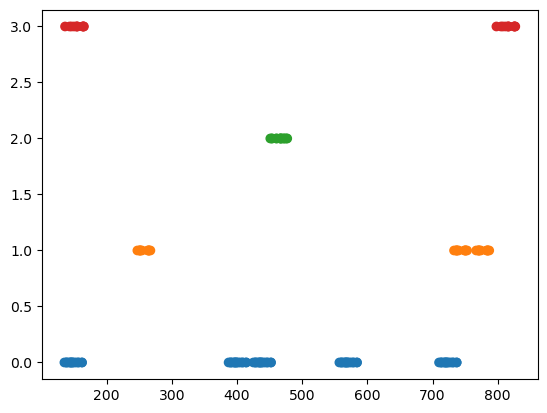

In [231]:
plt.figure()
plt.scatter(A_sparse[1],A_sparse[2],c=colors[M_labels])
plt.show()

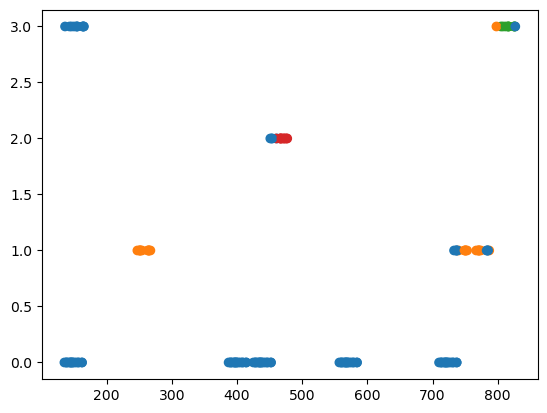

In [234]:
plt.figure()
plt.scatter(A_sparse[1],A_sparse[2],c=colors[pred-1])
plt.show()